## Importing all libraries

In [2]:
## Importing all libraries
import os
import io
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
folder_path = 'dataset/'
test_path = 'evaluation-set/'

column_names = ["labelId","serial","userId","inear(1=in)","timestamp","cmic_leq_a","cmic_peak_c","CDiag1","CDiag2","CDiag3","CDiag4","CDiag5","rmic_leq_a","rmic_peak_c","RDiag1","RDiag2","RDiag3","RDiag4","RDiag5","lmic_leq_a","lmic_peak_c","LDiag1","LDiag2","LDiag3","LDiag4","LDiag5","battv","flags","flags_ext","event_id","accel_mean","accel_peak","doseR","doseL","pmic_thmAvg"]
additional_columns = ["labelId","serial","userId","timestamp","cmic_leq_a","cmic_peak_c","rmic_leq_a","rmic_peak_c","lmic_leq_a","lmic_peak_c","battv","flags","flags_ext","event_id","accel_mean","accel_peak","doseR","doseL","pmic_thmAvg"]


In [5]:
# READING DATA FROM FILES AND CONCATENATING
def read_files_from_path(folder_path, combine=True):
    all_dataframes = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)        
            try:
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    # Removing the last comma from each line (due to bug with different number of columns in each row)
                    lines = [line.rstrip(',\n') for line in lines]
                    modified_csv = '\n'.join(lines)
                df = pd.read_csv(io.StringIO(modified_csv), skiprows=1,  header=None, names=column_names)
                if not df.empty:
                    all_dataframes[file_name] = df
            except pd.errors.ParserError as e:
                print(f"Error reading file '{file_name}': {e}")
            except pd.errors.EmptyDataError:
                print(f"No data to parse from file '{file_name}'")
    if combine: 
        combined_df = pd.concat(all_dataframes.values(), ignore_index=True)
        return combined_df
    return all_dataframes

# DISPLAYING IN/OUT DATA DISTRIBUTION IN THE DATAFRAME
def show_pie_chart_with_labels(dataframe):
    label_counts = dataframe['inear(1=in)'].value_counts()
    plt.figure(figsize=(6, 6))
    colors = ['#FFAA33', '#808080']  # Orange for IN-THE-EAR, Gray for OUT-OF-THE-EAR
    labels = ['IN-THE-EAR' if x == 1 else 'OUT-OF-THE-EAR' for x in label_counts.index]
    plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.show()
    

# DISPLAYING IN/OUT DATA DISTRIBUTION PER SERIAL IN DATAFRAME
def print_data_distribution_serial(dataframe):
    grouped_data = dataframe.groupby(['serial', 'inear(1=in)']).size().unstack(fill_value=0).rename(columns={1: 'IN-THE-EAR', 0: 'OUT-OF-THE-EAR'})
    colors = ['#FFAA33', '#808080']  # Orange for IN-THE-EAR and Gray for OUT-OF-THE-EAR
    ax = grouped_data[['IN-THE-EAR', 'OUT-OF-THE-EAR']].plot(kind='bar', figsize=(6, 6), color=colors)
    plt.xlabel('Serials')
    plt.ylabel('Number of Data Points')
    plt.xticks(rotation=0)
    plt.legend(title='Label')
    plt.show()
    
# CLEANING THE DATA
def delete_nans_and_columns(dataframe):
    dataframe.drop(columns=additional_columns, inplace=True)
    dataframe = dataframe.dropna()
    return dataframe

def plot_histograms(my_dataframe):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))
    in_color = '#FFAA33'  # Orange color for IN-THE-EAR
    out_color = '#808080'  # Gray color for OUT-OF-THE-EAR
    
    for i, column in enumerate(my_dataframe.columns[1:]):  # assuming the first column is 'inear(1=in)'
        sns.histplot(data=my_dataframe[my_dataframe['inear(1=in)'] == 0], x=column, ax=axes[i//5, i%5], bins=20, color=out_color, edgecolor='black')
        sns.histplot(data=my_dataframe[my_dataframe['inear(1=in)'] == 1], x=column, ax=axes[i//5, i%5], bins=20, color=in_color, edgecolor='black')
        
        axes[i//5, i%5].set_title(f'Histogram of {column}')
        axes[i//5, i%5].set_xlabel('Value')
        axes[i//5, i%5].set_ylabel('Frequency')
    
    plt.tight_layout(pad=3)
    plt.show()

def merge_left_and_right_data(dataframe):
    dataframe['Diag1'] = dataframe[['RDiag1', 'LDiag1']].values.tolist()
    dataframe['Diag2'] = dataframe[['RDiag2', 'LDiag2']].values.tolist()
    dataframe['Diag3'] = dataframe[['RDiag3', 'LDiag3']].values.tolist()
    dataframe['Diag4'] = dataframe[['RDiag4', 'LDiag4']].values.tolist()
    dataframe['Diag5'] = dataframe[['RDiag5', 'LDiag5']].values.tolist()
    dataframe = pd.DataFrame({
        'inear(1=in)': dataframe['inear(1=in)'].repeat(2),
        'Diag1': dataframe['Diag1'].explode(),
        'Diag2': dataframe['Diag2'].explode(),
        'Diag3': dataframe['Diag3'].explode(),
        'Diag4': dataframe['Diag4'].explode(),
        'Diag5': dataframe['Diag5'].explode(),
        'CDiag1': dataframe['CDiag1'].repeat(2),
        'CDiag2': dataframe['CDiag2'].repeat(2),
        'CDiag3': dataframe['CDiag3'].repeat(2),
        'CDiag4': dataframe['CDiag4'].repeat(2),
        'CDiag5': dataframe['CDiag5'].repeat(2)
    })
    dataframe.reset_index(drop=True, inplace=True)
    return dataframe

def print_stat_details(dataframe):
    dataframe = dataframe.apply(pd.to_numeric)
    stats = dataframe.describe(include = 'all')
    return stats

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def evaluate_model_metrics(y_test, y_new_pred, name="Model", only_accuracy=False):
    accuracy = accuracy_score(y_test, y_new_pred)
    if only_accuracy == False:
        precision = precision_score(y_test, y_new_pred)
        recall = recall_score(y_test, y_new_pred)
        spec = specificity(y_test, y_new_pred)
        f1 = f1_score(y_test, y_new_pred)
    print(f"{name} Metrics Values:")
    print(f"Accuracy: {accuracy:.2f}")
    if only_accuracy == False:
        metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": spec,
        "F1 Score": f1
        }
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"F1 Score: {f1:.2f}\n")
    else:
        metrics = {
        "Accuracy": accuracy
        }
    return metrics

def evaluate_model_metrics_cvs(model, name, X_train, y_train, cv):
    specificity_scorer = make_scorer(specificity)
    scores_accuracy = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    scores_precision = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    scores_recall = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')
    scores_specificity = cross_val_score(model, X_train, y_train, cv=cv, scoring=specificity_scorer)
    scores_f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')

    metrics = {
        "Accuracy": scores_accuracy,
        "Precision": scores_precision,
        "Recall": scores_recall,
        "Specificity": scores_specificity,
        "F1 Score": scores_f1
    }

    print(f"CV {name} Metrics Values:")
    print(f"CV Accuracy: {(scores_accuracy.mean()):.2f}")
    print(f"CV Precision: {(scores_precision.mean()):.2f}")
    print(f"CV Recall: {(scores_recall.mean()):.2f}")
    print(f"CV Specificity: {(scores_specificity.mean()):.2f}")
    print(f"CV F1 Score: {(scores_f1.mean()):.2f}\n")

    return metrics

def plot_general_accuracies_per_file(data_dict):
    num_results = len(data_dict)
    num_cols = 3
    num_rows = (num_results + num_cols - 1) // num_cols 
    model_names = ['K-NN', 'Linear SVC', 'Random Forest', 'MLP', 'Logistic Regression', 'Decision Tree']
    model_names1 = ['K-NN', 'Linear\nSVC', 'Random\nForest', 'MLP', 'Logistic\nRegression', 'Decision\nTree']
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 14)) 
    for i, (file_name, model_data) in enumerate(data_dict.items()):
        row = i // num_cols
        col = i % num_cols
        accuracies = [model_data[model]['Accuracy'] for model in model_names]

        axes[row, col].bar(model_names1, accuracies, color=['#555555', '#555555', '#555555', '#555555', '#555555', '#555555'])
        axes[row, col].set_ylabel('Accuracy', fontsize=14)
        axes[row, col].set_title(f'{file_name}', fontsize=18)
        axes[row, col].set_ylim(0, 1.1)  
        axes[row, col].tick_params(axis='x', labelsize=14)  
        axes[row, col].tick_params(axis='y', labelsize=12)  
        for j, accuracy in enumerate(accuracies):
            axes[row, col].text(j, accuracy + 0.02, f'{accuracy:.2f}', ha='center', fontsize=12)

    for j in range(i + 1, num_rows * num_cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


def plot_all_accuracies(data_dict):
    n = len(data_dict)
    cols = 3  
    rows = (n + cols - 1) // cols  

    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))
    axes = axes.flatten() 
    
    for i, (file_name, models_data) in enumerate(data_dict.items()):
        labels = list(models_data.keys())
        formatted_labels = [label.replace(' ', '\n') for label in labels]
        right_scores = [models_data[model]['Right']['Accuracy'] for model in labels]
        left_scores = [models_data[model]['Left']['Accuracy'] for model in labels]
        x = np.arange(len(labels))
        width = 0.35
        axes[i].bar(x - width/2, right_scores, width, label='Right', color='#CC3333')
        axes[i].bar(x + width/2, left_scores, width, label='Left', color='#336699')
        title = (f"{file_name}")
        axes[i].set_ylabel('Accuracy', fontsize=14)
        axes[i].set_title(title, fontsize=18)
        axes[i].set_ylim([0, 1.1])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(formatted_labels, rotation=0)
        axes[i].tick_params(axis='x', labelsize=14)
        axes[i].tick_params(axis='y', labelsize=12)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    

## Data Acquisition

In [6]:
combined_df = read_files_from_path(folder_path)

## Exploratory Data Analysis & Visualisation

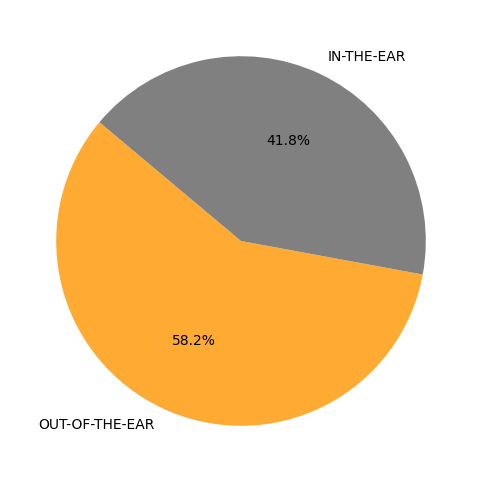

In [7]:
show_pie_chart_with_labels(combined_df)

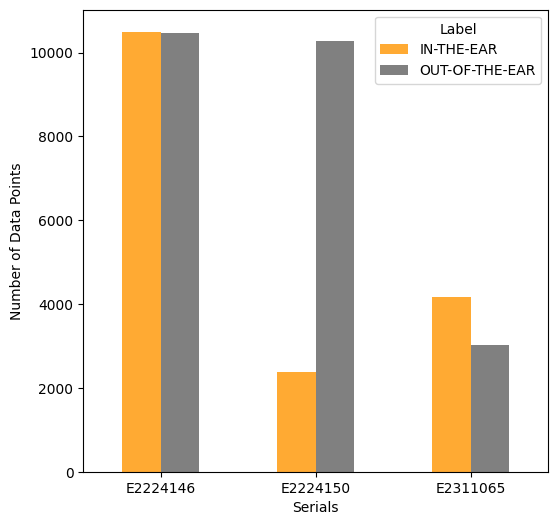

In [8]:
print_data_distribution_serial(combined_df)

## Data Preparation and Feature Engineering

In [9]:
combined_df = delete_nans_and_columns(combined_df)

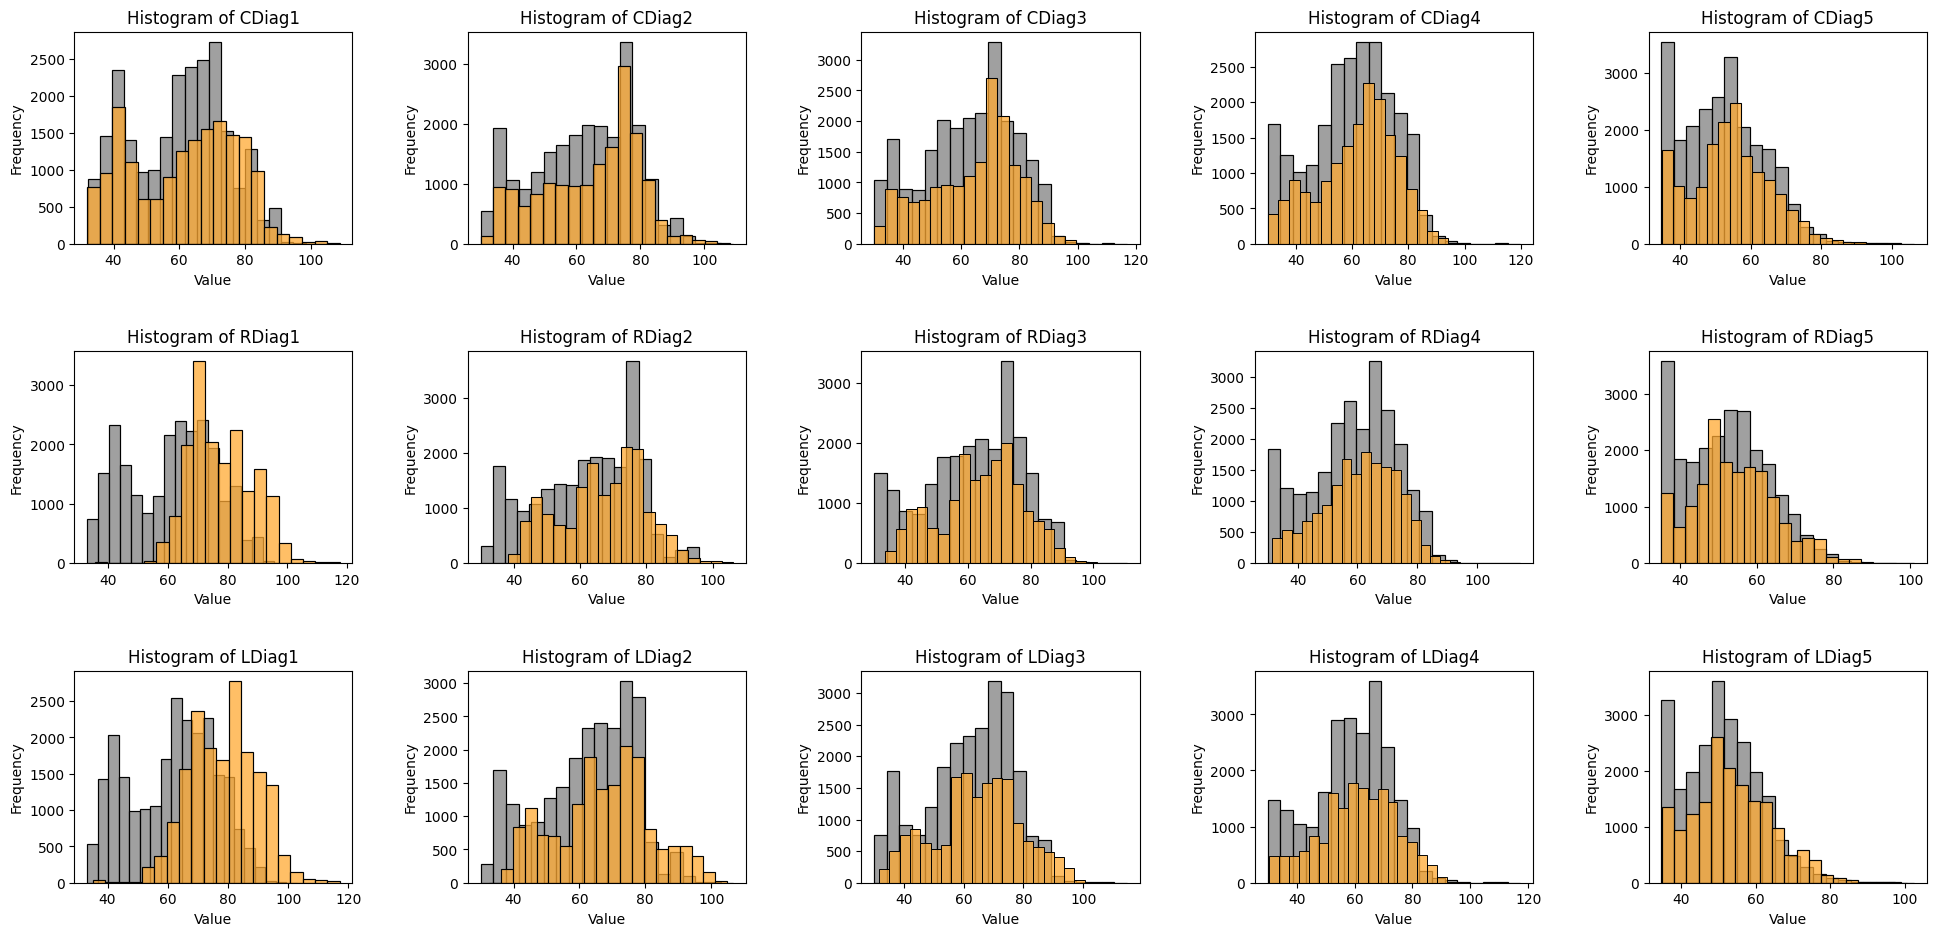

In [10]:
plot_histograms(combined_df)

In [11]:
combined_df = merge_left_and_right_data(combined_df)

In [12]:
stats = print_stat_details(combined_df)
stats

,inear(1=in),Diag1,Diag2,Diag3,Diag4,Diag5,CDiag1,CDiag2,CDiag3,CDiag4,CDiag5
count,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000,81564.000000
mean,0.417782,68.314822,64.205147,62.793978,59.567526,52.545669,60.640922,63.204216,63.334465,60.839239,52.988825
std,0.493197,15.526280,14.543539,14.576808,13.439340,10.645572,15.157582,15.467601,15.558807,14.330521,11.229296
min,0.000000,32.871094,30.000000,30.000000,30.000000,34.716797,31.933594,30.000000,30.000000,30.000000,34.687500
25%,0.000000,59.853516,53.466797,53.144531,51.210938,44.736328,46.054688,51.298828,52.119141,51.591797,44.296875
50%,0.000000,69.814453,65.830078,64.423828,60.761719,51.943359,62.578125,65.771484,66.064453,62.929688,52.968750
75%,1.000000,79.746094,75.527344,73.300781,69.462891,59.677734,72.099609,75.556641,74.531250,71.220703,60.673828
max,1.000000,117.568359,106.757813,114.667969,117.304688,102.421875,108.867188,109.130859,117.011719,119.882813,106.289063


In [13]:
X = combined_df.drop(columns=['inear(1=in)']) 
y = combined_df['inear(1=in)']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

## Modeling and Training

In [16]:
knn = KNeighborsClassifier()
linear_svc = LinearSVC()
random_forest = RandomForestClassifier()
mlp = MLPClassifier()
log_reg = LogisticRegression()
decision_tree = DecisionTreeClassifier()

models = [knn, linear_svc, random_forest, mlp, log_reg, decision_tree]
model_names = ['K-NN', 'Linear SVC', 'Random Forest', 'MLP', 'Logistic Regression', 'Decision Tree']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

In [17]:
for model, name in zip(models, model_names):
    evaluate_model_metrics_cvs(model, name, X_train, y_train, cv)

In [18]:
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model_metrics(y_test, y_pred, name)

K-NN Metrics Values:
Accuracy: 0.88
Precision: 0.87
Recall: 0.84
Specificity: 0.91
F1 Score: 0.86



/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC Metrics Values:
Accuracy: 0.85
Precision: 0.86
Recall: 0.76
Specificity: 0.91
F1 Score: 0.81

Random Forest Metrics Values:
Accuracy: 0.86
Precision: 0.84
Recall: 0.82
Specificity: 0.89
F1 Score: 0.83



/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Metrics Values:
Accuracy: 0.91
Precision: 0.94
Recall: 0.85
Specificity: 0.96
F1 Score: 0.89

Logistic Regression Metrics Values:
Accuracy: 0.85
Precision: 0.85
Recall: 0.77
Specificity: 0.90
F1 Score: 0.81

Decision Tree Metrics Values:
Accuracy: 0.85
Precision: 0.82
Recall: 0.81
Specificity: 0.88
F1 Score: 0.82



## Evaluation and Visualisation

In [19]:
combined_evaluation_df = read_files_from_path(test_path, False)    

In [20]:
general_accuracies_per_file = {}
for df_entry in combined_evaluation_df:
    df = delete_nans_and_columns(combined_evaluation_df[df_entry].copy())
    df = merge_left_and_right_data(df)
    df.reset_index(drop=True, inplace=True)
    X_val2 = df.drop(columns=['inear(1=in)'])  # Features
    y_val2 = df['inear(1=in)']  # Target
    X_val2_scaled = scaler.transform(X_val2)
    file_metrics = {}
    for model, name in zip(models, model_names):
        y_new2_pred = model.predict(X_val2_scaled)  # Predict on the new scaled test data
        metrics = evaluate_model_metrics(y_val2, y_new2_pred, name, True)
        file_metrics[name] = metrics
    general_accuracies_per_file[df_entry] = file_metrics

K-NN Metrics Values:
Accuracy: 0.99
Linear SVC Metrics Values:
Accuracy: 1.00
Random Forest Metrics Values:
Accuracy: 0.99
MLP Metrics Values:
Accuracy: 0.98
Logistic Regression Metrics Values:
Accuracy: 1.00
Decision Tree Metrics Values:
Accuracy: 0.92
K-NN Metrics Values:
Accuracy: 0.77
Linear SVC Metrics Values:
Accuracy: 1.00
Random Forest Metrics Values:
Accuracy: 0.88
MLP Metrics Values:
Accuracy: 0.85
Logistic Regression Metrics Values:
Accuracy: 1.00
Decision Tree Metrics Values:
Accuracy: 0.87
K-NN Metrics Values:
Accuracy: 0.98
Linear SVC Metrics Values:
Accuracy: 0.71
Random Forest Metrics Values:
Accuracy: 0.96
MLP Metrics Values:
Accuracy: 0.99
Logistic Regression Metrics Values:
Accuracy: 0.74
Decision Tree Metrics Values:
Accuracy: 0.85
K-NN Metrics Values:
Accuracy: 0.97
Linear SVC Metrics Values:
Accuracy: 0.97
Random Forest Metrics Values:
Accuracy: 0.98
MLP Metrics Values:
Accuracy: 0.95
Logistic Regression Metrics Values:
Accuracy: 0.97
Decision Tree Metrics Values:

In [21]:
general_accuracies_per_file

{'IN_vacuuming.csv': {'K-NN': {'Accuracy': 0.9868131868131869},
  'Linear SVC': {'Accuracy': 0.9972527472527473},
  'Random Forest': {'Accuracy': 0.9912087912087912},
  'MLP': {'Accuracy': 0.9829670329670329},
  'Logistic Regression': {'Accuracy': 0.9989010989010989},
  'Decision Tree': {'Accuracy': 0.9197802197802197}},
 'OUT_train-ride.csv': {'K-NN': {'Accuracy': 0.7720156555772995},
  'Linear SVC': {'Accuracy': 0.99706457925636},
  'Random Forest': {'Accuracy': 0.8767123287671232},
  'MLP': {'Accuracy': 0.8473581213307241},
  'Logistic Regression': {'Accuracy': 0.99706457925636},
  'Decision Tree': {'Accuracy': 0.8708414872798435}},
 'IN_train-ride.csv': {'K-NN': {'Accuracy': 0.9844213649851632},
  'Linear SVC': {'Accuracy': 0.7136498516320475},
  'Random Forest': {'Accuracy': 0.9577151335311572},
  'MLP': {'Accuracy': 0.9910979228486647},
  'Logistic Regression': {'Accuracy': 0.7403560830860534},
  'Decision Tree': {'Accuracy': 0.8501483679525222}},
 'OUT_office-sounds.csv': {'K-NN

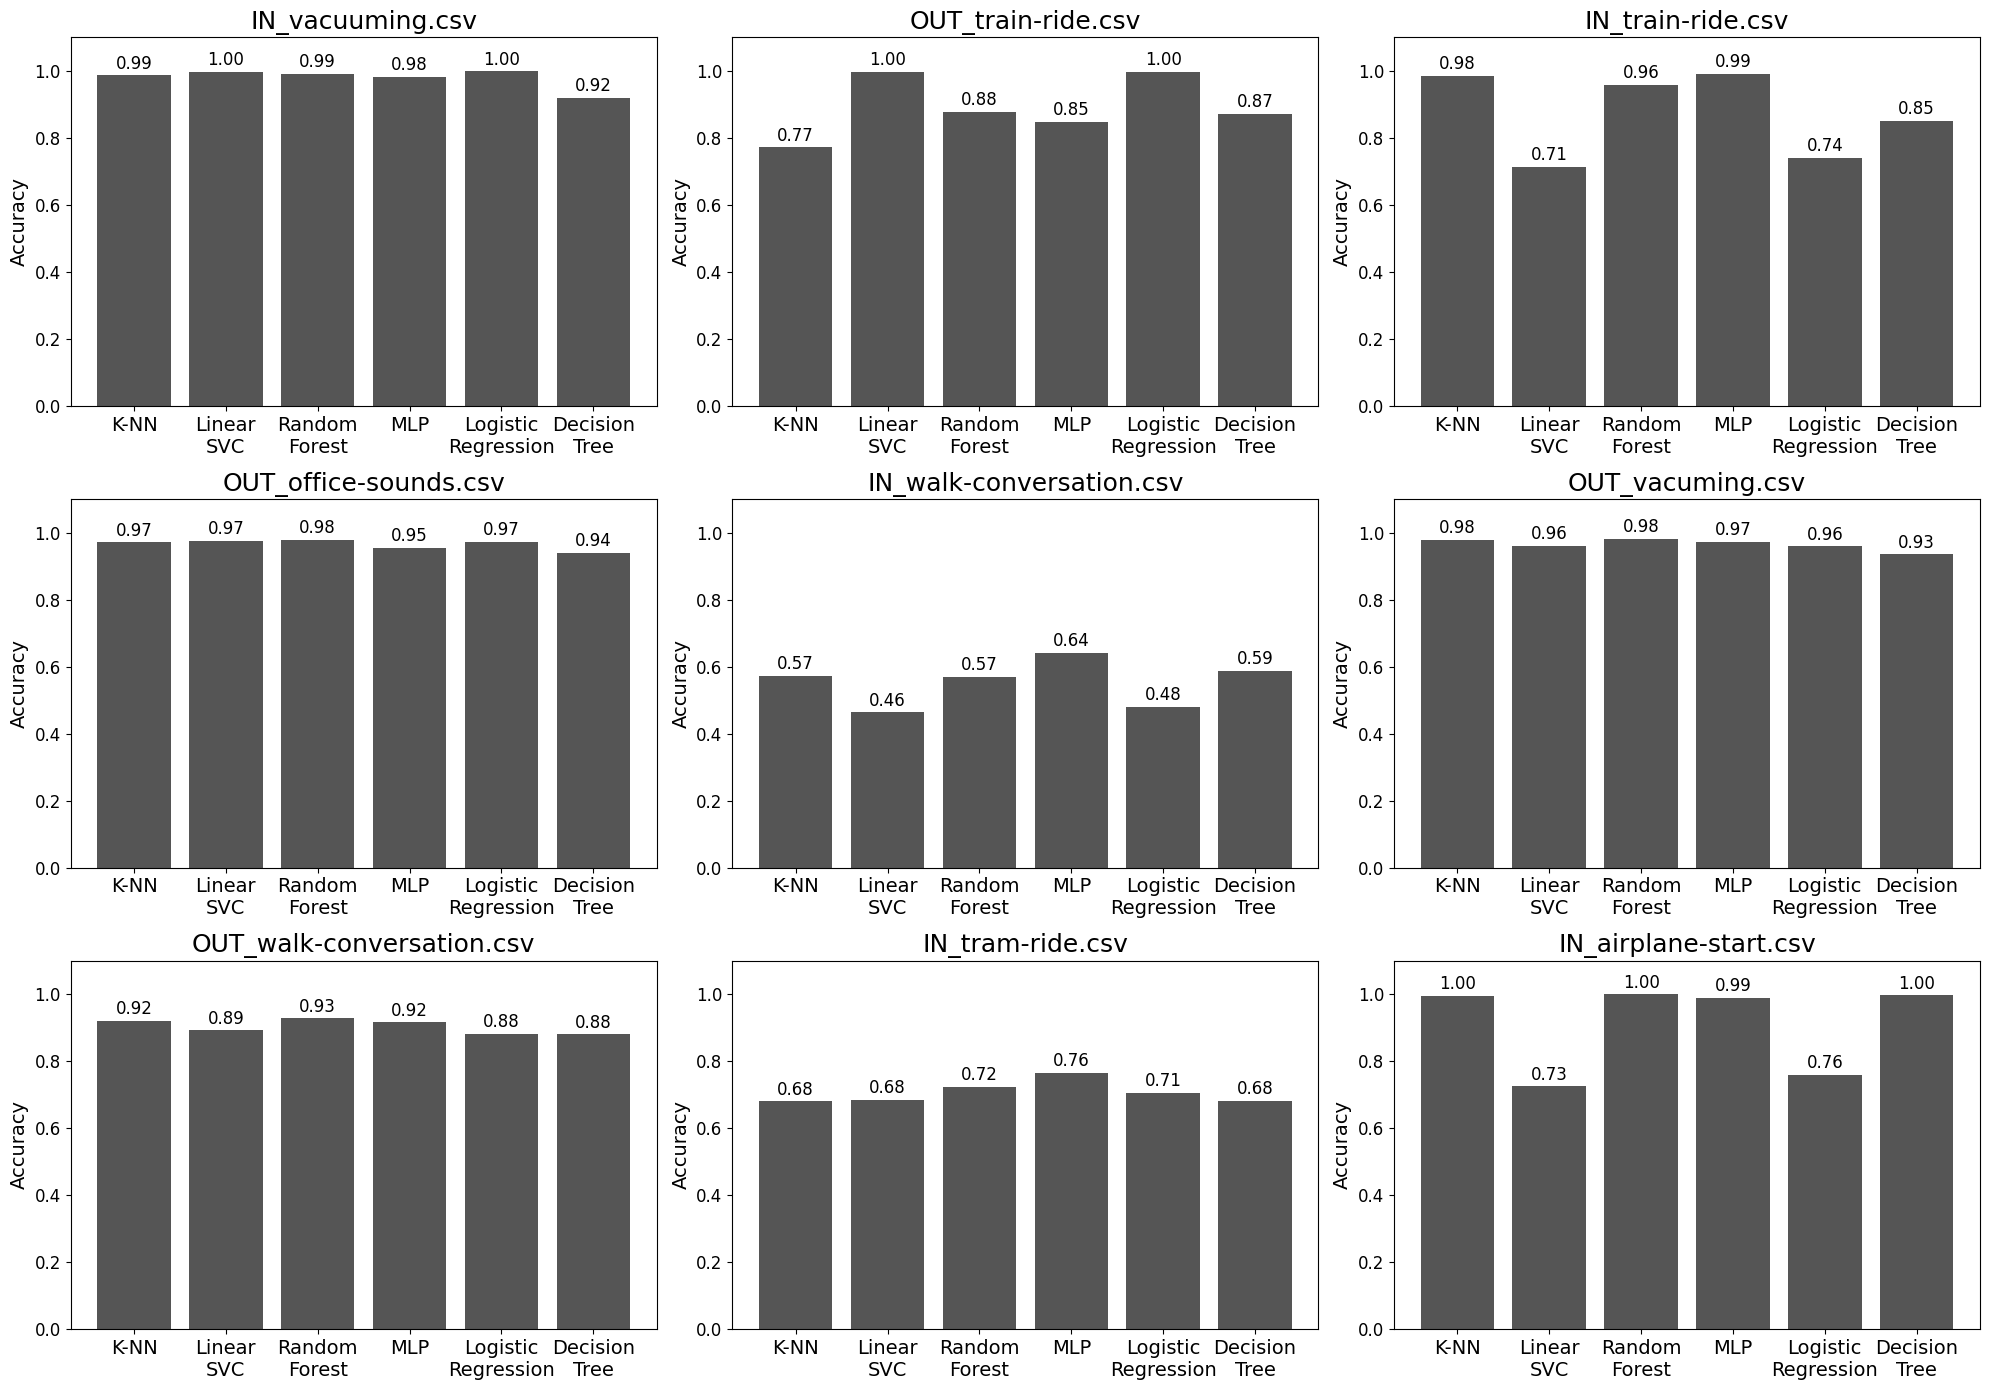

In [22]:
plot_general_accuracies_per_file(general_accuracies_per_file)

In [23]:
split_accuracies_per_file = {}
for df_entry in combined_evaluation_df:
    df = delete_nans_and_columns(combined_evaluation_df[df_entry].copy())
    df_right = df[['inear(1=in)', 'RDiag1', 'RDiag2', 'RDiag3', 'RDiag4', 'RDiag5', 'CDiag1', 'CDiag2', 'CDiag3', 'CDiag4', 'CDiag5']]
    df_left = df[['inear(1=in)', 'LDiag1', 'LDiag2', 'LDiag3', 'LDiag4', 'LDiag5', 'CDiag1', 'CDiag2', 'CDiag3', 'CDiag4', 'CDiag5']]
    df_right = df_right.rename(columns={
                            'RDiag1': 'Diag1',
                            'RDiag2': 'Diag2',
                            'RDiag3': 'Diag3',
                            'RDiag4': 'Diag4',
                            'RDiag5': 'Diag5'
                        })
    df_left = df_left.rename(columns={
                            'LDiag1': 'Diag1',
                            'LDiag2': 'Diag2',
                            'LDiag3': 'Diag3',
                            'LDiag4': 'Diag4',
                            'LDiag5': 'Diag5'
                        })
    X_right = df_right.drop(columns=['inear(1=in)'])  
    y_right = df_right['inear(1=in)'] 
    X_left = df_left.drop(columns=['inear(1=in)']) 
    y_left = df_left['inear(1=in)'] 
    X_right_scaled = scaler.transform(X_right) 
    X_left_scaled = scaler.transform(X_left) 
    file_metrics = {}
    for model, name in zip(models, model_names):
        y_right_pred = model.predict(X_right_scaled) 
        right_metrics = evaluate_model_metrics(y_right, y_right_pred, name, True)
        y_left_pred = model.predict(X_left_scaled) 
        left_metrics = evaluate_model_metrics(y_left, y_left_pred, name, True)
        metrics = {}
        metrics['Right'] = right_metrics
        metrics['Left'] = left_metrics
        file_metrics[name] = metrics
    split_accuracies_per_file[df_entry] = file_metrics
    

K-NN Metrics Values:
Accuracy: 0.99
K-NN Metrics Values:
Accuracy: 0.98
Linear SVC Metrics Values:
Accuracy: 1.00
Linear SVC Metrics Values:
Accuracy: 0.99
Random Forest Metrics Values:
Accuracy: 1.00
Random Forest Metrics Values:
Accuracy: 0.98
MLP Metrics Values:
Accuracy: 0.99
MLP Metrics Values:
Accuracy: 0.97
Logistic Regression Metrics Values:
Accuracy: 1.00
Logistic Regression Metrics Values:
Accuracy: 1.00
Decision Tree Metrics Values:
Accuracy: 0.92
Decision Tree Metrics Values:
Accuracy: 0.92
K-NN Metrics Values:
Accuracy: 0.68
K-NN Metrics Values:
Accuracy: 0.86
Linear SVC Metrics Values:
Accuracy: 1.00
Linear SVC Metrics Values:
Accuracy: 1.00
Random Forest Metrics Values:
Accuracy: 0.78
Random Forest Metrics Values:
Accuracy: 0.97
MLP Metrics Values:
Accuracy: 0.69
MLP Metrics Values:
Accuracy: 1.00
Logistic Regression Metrics Values:
Accuracy: 1.00
Logistic Regression Metrics Values:
Accuracy: 1.00
Decision Tree Metrics Values:
Accuracy: 0.85
Decision Tree Metrics Values:

In [24]:
split_accuracies_per_file

{'IN_vacuuming.csv': {'K-NN': {'Right': {'Accuracy': 0.9934065934065934},
   'Left': {'Accuracy': 0.9802197802197802}},
  'Linear SVC': {'Right': {'Accuracy': 1.0},
   'Left': {'Accuracy': 0.9945054945054945}},
  'Random Forest': {'Right': {'Accuracy': 0.9978021978021978},
   'Left': {'Accuracy': 0.9846153846153847}},
  'MLP': {'Right': {'Accuracy': 0.9923076923076923},
   'Left': {'Accuracy': 0.9736263736263736}},
  'Logistic Regression': {'Right': {'Accuracy': 1.0},
   'Left': {'Accuracy': 0.9978021978021978}},
  'Decision Tree': {'Right': {'Accuracy': 0.9164835164835164},
   'Left': {'Accuracy': 0.9230769230769231}}},
 'OUT_train-ride.csv': {'K-NN': {'Right': {'Accuracy': 0.6829745596868885},
   'Left': {'Accuracy': 0.8610567514677103}},
  'Linear SVC': {'Right': {'Accuracy': 0.9960861056751468},
   'Left': {'Accuracy': 0.9980430528375733}},
  'Random Forest': {'Right': {'Accuracy': 0.7808219178082192},
   'Left': {'Accuracy': 0.9726027397260274}},
  'MLP': {'Right': {'Accuracy': 0.

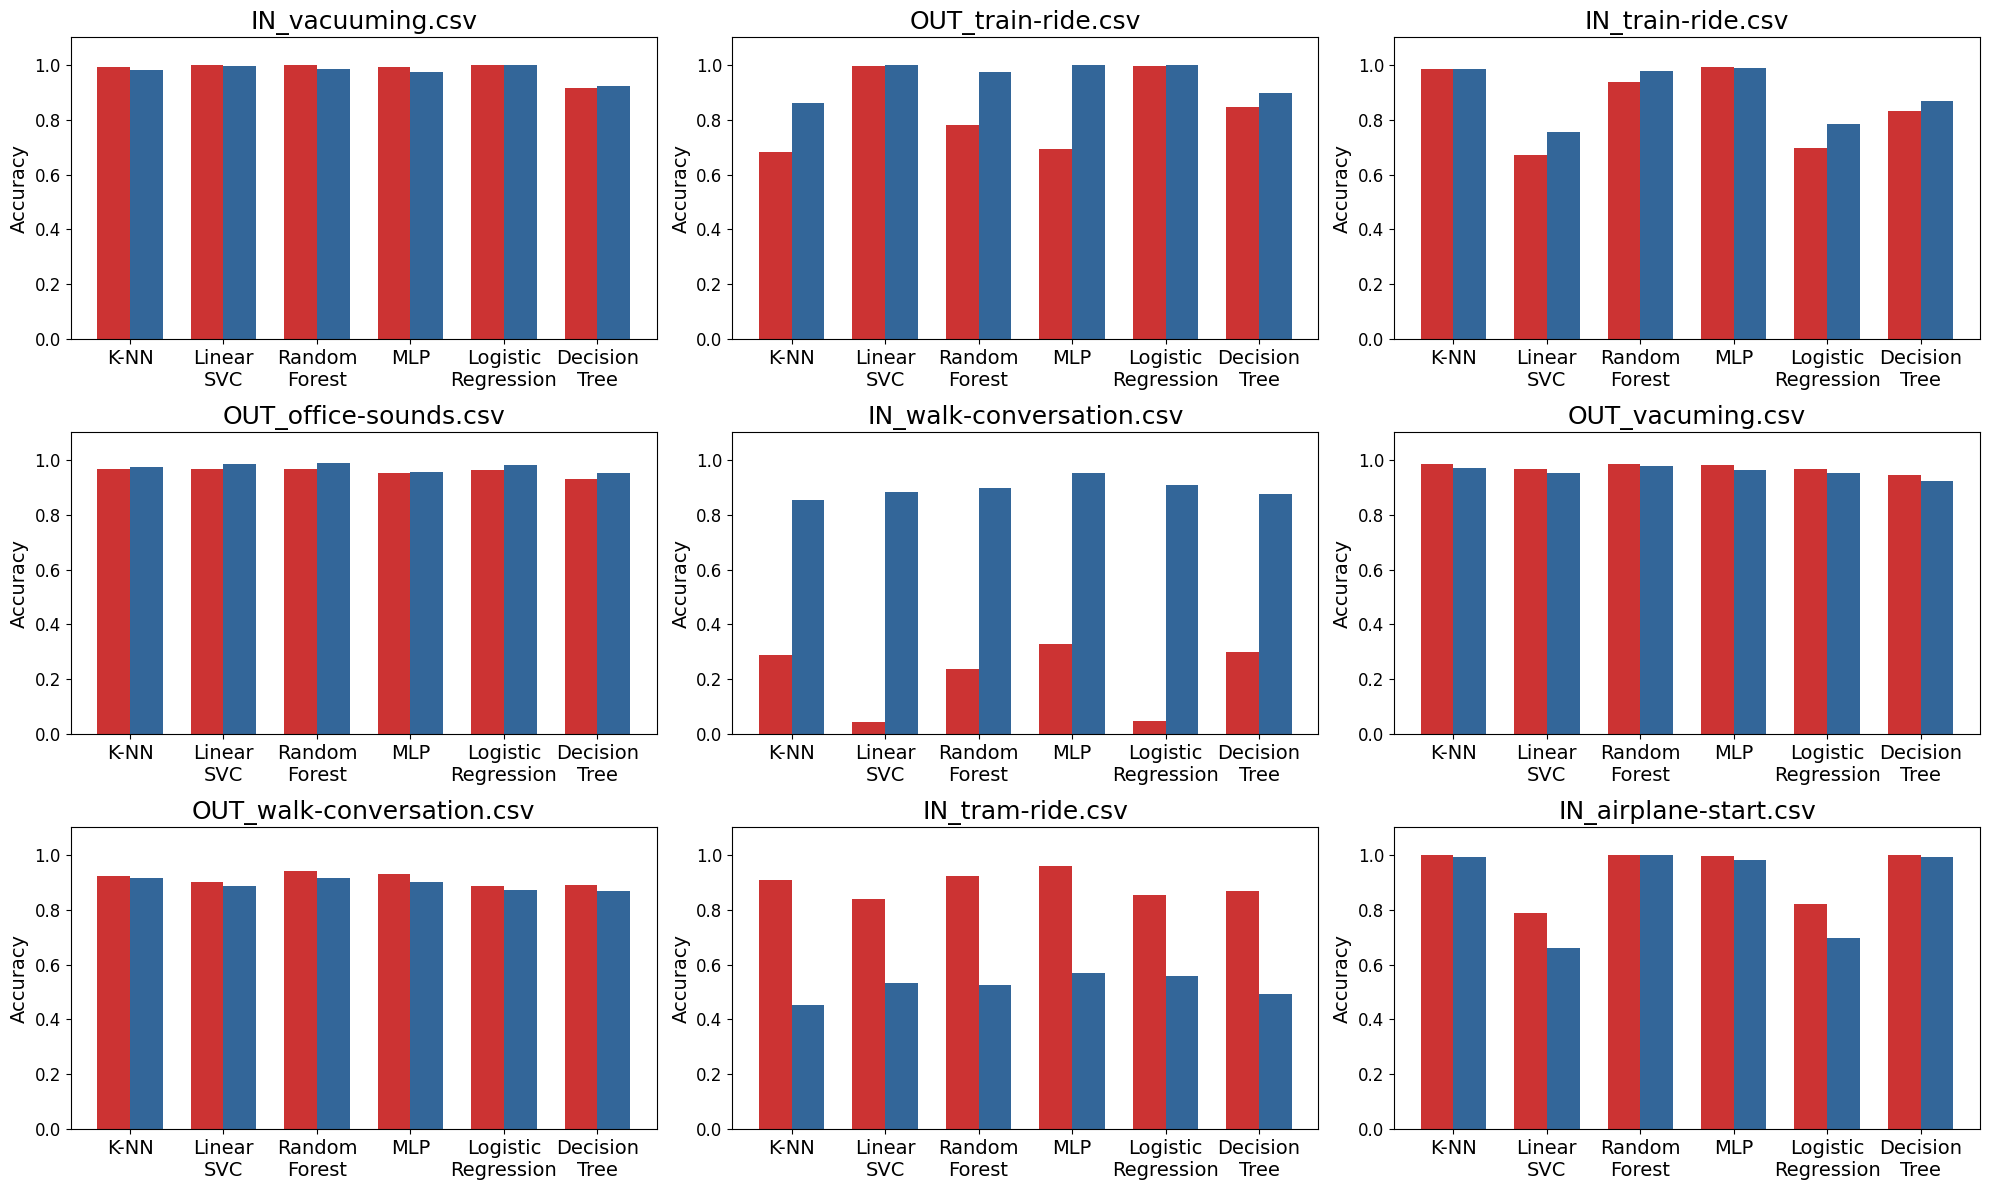

In [25]:
plot_all_accuracies(split_accuracies_per_file)

In [26]:
combined_evaluation_df = read_files_from_path(test_path)  
combined_evaluation_df = delete_nans_and_columns(combined_evaluation_df)
combined_evaluation_df = merge_left_and_right_data(combined_evaluation_df)

In [27]:
X_evaluation_test = combined_evaluation_df.drop(columns=['inear(1=in)'])
y_evaluation_test = combined_evaluation_df['inear(1=in)']
X_evaluation_test_scaled = scaler.transform(X_evaluation_test) 

In [28]:
for model, name in zip(models, model_names):
    y_new_pred = model.predict(X_evaluation_test_scaled)  
    metrics = evaluate_model_metrics(y_evaluation_test, y_new_pred, name)

K-NN Metrics Values:
Accuracy: 0.87
Precision: 0.92
Recall: 0.77
Specificity: 0.95
F1 Score: 0.84

Linear SVC Metrics Values:
Accuracy: 0.82
Precision: 0.92
Recall: 0.67
Specificity: 0.95
F1 Score: 0.77

Random Forest Metrics Values:
Accuracy: 0.88
Precision: 0.94
Recall: 0.78
Specificity: 0.96
F1 Score: 0.85

MLP Metrics Values:
Accuracy: 0.89
Precision: 0.92
Recall: 0.82
Specificity: 0.94
F1 Score: 0.86

Logistic Regression Metrics Values:
Accuracy: 0.83
Precision: 0.91
Recall: 0.69
Specificity: 0.95
F1 Score: 0.78

Decision Tree Metrics Values:
Accuracy: 0.85
Precision: 0.88
Recall: 0.76
Specificity: 0.92
F1 Score: 0.81

